# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» доступны данные о пробах нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель** — компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

**Задача исследования** — построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски необходимо техникой *Bootstrap*.

Известны следующие шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**  
•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).    
•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.    
•	Бюджет на разработку скважин в регионе — 10 млрд рублей.    
•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.    
•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.    

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


**Исследование пройдёт в пять этапов:**
 1. Загрузка и подготовка данных;
 2. Обучение и проверка модели;
 3. Подготовка к расчёту прибыли;
 4. Расчет прибыли и рисков;
 5. Общий вывод.

## Загрузка и подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

Данные для исследования получаем из файлов `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`:

In [3]:
# чтение файлов с данными и сохранение в df
try:
    df_geo_0 = pd.read_csv('datasets/geo_data_0.csv')
except:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    
try:
    df_geo_1 = pd.read_csv('datasets/geo_data_1.csv')
except:
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    
try:
    df_geo_2 = pd.read_csv('datasets/geo_data_2.csv')
except:
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# получение первых пяти строк таблиц
display(df_geo_0.head())
display(df_geo_1.head())
display(df_geo_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Описание данных**

*Признаки:*
*	`id` — уникальный идентификатор скважины;
*	`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);    

*Целевой признак:*
*	`product` — объём запасов в скважине (тыс. баррелей).


**Обработка пропусков**

In [5]:
# подсчёт доли пропусков 
display(df_geo_0.isna().mean())
display(df_geo_1.isna().mean())
display(df_geo_2.isna().mean())

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

В данных не содержится пропусков

**Приведение данных к корректному типу**

In [6]:
# получение информации о типах данных
display(df_geo_0.dtypes)
display(df_geo_1.dtypes)
display(df_geo_2.dtypes)

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Чтобы сэкономить память и процессорное время при обработке данных изменим тип данных на более оптимальный:

In [7]:
# изменение типа данных на float32
df_geo_0['f0'] = pd.to_numeric(df_geo_0['f0'], downcast='float')
df_geo_0['f1'] = pd.to_numeric(df_geo_0['f1'], downcast='float')
df_geo_0['f2'] = pd.to_numeric(df_geo_0['f2'], downcast='float')
df_geo_0['product'] = pd.to_numeric(df_geo_0['product'], downcast='float')

df_geo_1['f0'] = pd.to_numeric(df_geo_1['f0'], downcast='float')
df_geo_1['f1'] = pd.to_numeric(df_geo_1['f1'], downcast='float')
df_geo_1['f2'] = pd.to_numeric(df_geo_1['f2'], downcast='float')
df_geo_1['product'] = pd.to_numeric(df_geo_1['product'], downcast='float')

df_geo_2['f0'] = pd.to_numeric(df_geo_2['f0'], downcast='float')
df_geo_2['f1'] = pd.to_numeric(df_geo_2['f1'], downcast='float')
df_geo_2['f2'] = pd.to_numeric(df_geo_2['f2'], downcast='float')
df_geo_2['product'] = pd.to_numeric(df_geo_2['product'], downcast='float')

**Поиск и обработка дубликатов**

In [8]:
# подсчет явных дубликатов
print("Явных дубликатов в df_geo_0:", df_geo_0.duplicated().sum())
print("Явных дубликатов в df_geo_1:", df_geo_1.duplicated().sum())
print("Явных дубликатов в df_geo_2:", df_geo_2.duplicated().sum())

Явных дубликатов в df_geo_0: 0
Явных дубликатов в df_geo_1: 0
Явных дубликатов в df_geo_2: 0


Явные дубликаты в данных не обнаружены, однако в колонке id содержатся значения в различном регистре — приведем данные к нижнему регистру и проверим на наличие дубликатов:

In [9]:
print("Дубликатов в df_geo_0, колонке id:", df_geo_0['id'].str.lower().duplicated().sum())
print("Дубликатов в df_geo_1, колонке id:", df_geo_1['id'].str.lower().duplicated().sum())
print("Дубликатов в df_geo_2, колонке id:", df_geo_2['id'].str.lower().duplicated().sum())

Дубликатов в df_geo_0, колонке id: 113
Дубликатов в df_geo_1, колонке id: 113
Дубликатов в df_geo_2, колонке id: 99


В колонке id содержатся дубликаты, однако никакие методы обработки к ним применять не будем, т.к. эта колонка в дальнейшем будет удалена, как не представляющая ценности на построения модели.

**Поиск аномалий в данных**

In [10]:
# числовое описание данных
df_geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500417,0.250143,2.502660,92.500832
std,0.871825,0.504431,3.248227,44.288460
min,-1.408605,-0.848219,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564087
max,2.362331,1.343769,16.003790,185.364349


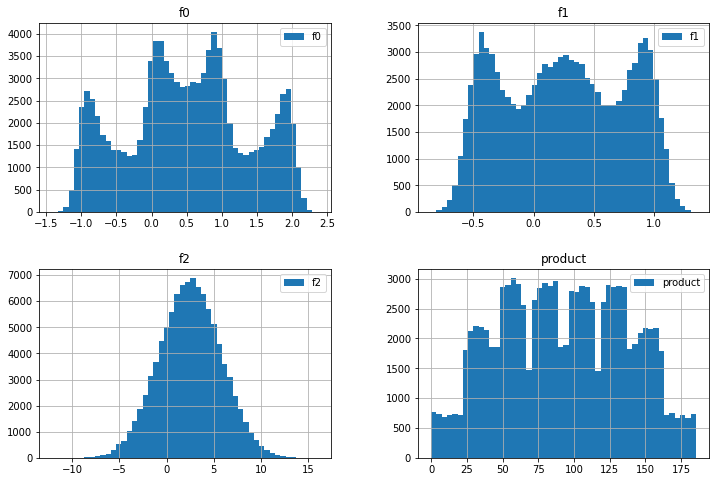

In [11]:
# распределение
df_geo_0.hist(bins=50, figsize=(12,8), legend=True);

In [12]:
# подсчет нулевых значений
df_geo_0[df_geo_0['product'] == 0]['product'].count()

1

In [13]:
# числовое описание данных
df_geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796567,2.494537,68.838837
std,8.965897,5.119843,1.703575,45.942646
min,-31.609575,-26.358599,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953260
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621016,-1.332816,3.999904,107.813042
max,29.421755,18.734062,5.019721,137.945404


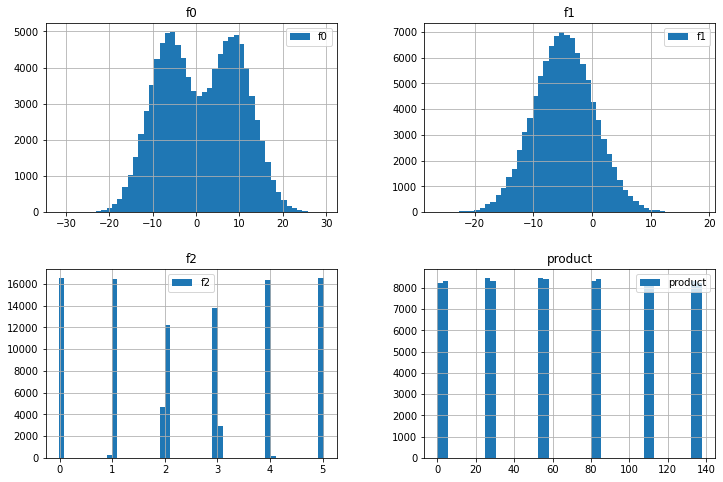

In [14]:
# распределение
df_geo_1.hist(bins=50, figsize=(12,8), legend=True);

In [15]:
# подсчет нулевых значений
print(df_geo_1[df_geo_1['product'] == 0]['product'].count(), '\n')
print('{:.1%}'.format(df_geo_1[df_geo_1['product'] == 0]['product'].count()/len(df_geo_1)))

8235 

8.2%


In [16]:
display(df_geo_1[df_geo_1['product'] == 0].head(10))

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893513,-0.001601,0.0
81,gdvra,-3.246882,-7.979657,0.009027,0.0
82,VHp5v,15.363643,-6.456659,0.004302,0.0
83,dm9rM,13.494966,-0.543358,0.001352,0.0
127,6az0U,13.951600,-5.077510,-0.005232,0.0
128,iDXiz,6.820803,5.220184,-0.007179,0.0


В таблице df_geo_1 находится 8235 значений с нулевыми данными об объёме запасов нефти в скважине, что составляет 8.2% от объема датафрейма. Так как в остальных датасетах нулевые значения практически отсутствуют, можно предположить что это вручную внесенные данные (возможно заполнение пропусков). Удалим эти значения, чтобы они не оказывали влияние на нашу модель:

In [17]:
# удаление нулевых значений
df_geo_1 = df_geo_1[df_geo_1['product'] != 0]

In [18]:
# подсчет нулевых значений
print(df_geo_1[df_geo_1['product'] == 0]['product'].count(), '\n')
print('{:.1%}'.format(df_geo_1[df_geo_1['product'] == 0]['product'].count()/len(df_geo_1)))

0 

0.0%


In [19]:
# числовое описание данных
df_geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495123,94.998749
std,1.732035,1.730408,3.473415,44.749722
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450439
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595024
max,7.238263,7.844801,16.739403,190.029831


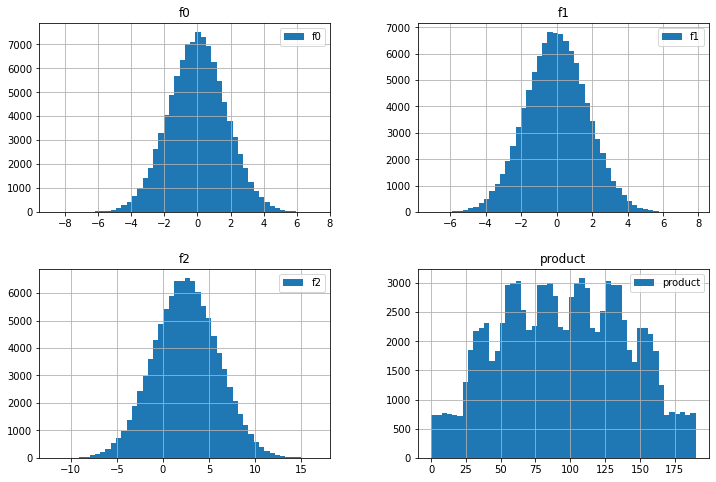

In [20]:
# распределение
df_geo_2.hist(bins=50, figsize=(12,8), legend=True);

In [21]:
# подсчет нулевых значений
df_geo_2[df_geo_2['product'] == 0]['product'].count()

1

### Выводы

💡 В исходном файле содержатся данные о пробах нефти в трёх регионах по каждому из 10 000 месторождений, где были измерено качество нефти и объём её запасов. 

В ходе первичного анализа данных было выявлено:     

* В названии колонок не обнаружено нарушение стиля;    

* Явных пропусков и дубликатов в данных не наблюдается, однако в колонке id содержатся неявные дубликаты — принято решение оставить их как есть, т.к. эта колонка в дальнейшем будет удалена, как не представляющая ценности на построения модели;         
* Данные были приведены к соответствующему вещественному типу;    

* В таблице df_geo_1 находится 8235 значений с нулевыми данными об объёме запасов нефти в скважине, что составляет 8.2% от объема датафрейма. Нулевые значения были удалены.

## Обучение и проверка модели

### Подготовка признаков

**Удаление лишних столбцов из датафреймов**

Удалим столбец с id не представляющий ценности для обучения моделей:

In [22]:
data_geo_0 = df_geo_0.drop(['id'], axis=1).copy()
data_geo_1 = df_geo_1.drop(['id'], axis=1).copy()
data_geo_2 = df_geo_2.drop(['id'], axis=1).copy()

display(data_geo_0.head(3))
display(data_geo_1.head(3))
display(data_geo_2.head(3))

,f0,f1,f2,product
0,0.705745,-0.497822,1.221170,105.280060
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265648


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953260
2,6.263187,-5.948386,5.001160,134.766312


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530186,56.069698
2,0.194587,0.289035,-5.586433,62.871910


**Разделение данных на выборки**

Разделим данные на обучающую (75%), валидационную (25%).

In [23]:
# разделение данных на обучающую и валидационную выборки
df_0_train, df_0_valid = train_test_split(data_geo_0.copy(), train_size=0.75, test_size=0.25, random_state=12345)

In [24]:
print("Процент данных в обучающей выборке:", '{:.0%}'.format(len(df_0_train)/len(data_geo_0)))
print("Процент данных в валидационной выборке", '{:.0%}'.format(len(df_0_valid)/len(data_geo_0)))

Процент данных в обучающей выборке: 75%
Процент данных в валидационной выборке 25%


In [25]:
# разделение данных на обучающую и валидационную выборки
df_1_train, df_1_valid = train_test_split(data_geo_1.copy(), train_size=0.75, test_size=0.25, random_state=12345)

In [26]:
print("Процент данных в обучающей выборке:", '{:.0%}'.format(len(df_1_train)/len(data_geo_1)))
print("Процент данных в валидационной выборке", '{:.0%}'.format(len(df_1_valid)/len(data_geo_1)))

Процент данных в обучающей выборке: 75%
Процент данных в валидационной выборке 25%


In [27]:
# разделение данных на обучающую и валидационную выборки
df_2_train, df_2_valid = train_test_split(data_geo_2.copy(), train_size=0.75, test_size=0.25, random_state=12345)

In [28]:
print("Процент данных в обучающей выборке:", '{:.0%}'.format(len(df_2_train)/len(data_geo_2)))
print("Процент данных в валидационной выборке", '{:.0%}'.format(len(df_2_valid)/len(data_geo_2)))

Процент данных в обучающей выборке: 75%
Процент данных в валидационной выборке 25%


In [29]:
# определение функции для создания переменных для признаков и целевого признака
def splitting_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [30]:
# cоздание переменных для признаков и целевого признака
features_0_train, target_0_train = splitting_data(df_0_train, 'product')
features_0_valid, target_0_valid = splitting_data(df_0_valid, 'product')

features_1_train, target_1_train = splitting_data(df_1_train, 'product')
features_1_valid, target_1_valid = splitting_data(df_1_valid, 'product')

features_2_train, target_2_train = splitting_data(df_2_train, 'product')
features_2_valid, target_2_valid = splitting_data(df_2_valid, 'product')

In [31]:
# проверка суммы значений
print("Сумма значений новых выборок df_0:", len(features_0_train) + len(features_0_valid))
print("Количество значений исходной выборки:", len(data_geo_0), '\n')

print("Сумма значений новых выборок df_1:", len(features_1_train) + len(features_1_valid))
print("Количество значений исходной выборки:", len(data_geo_1), '\n')

print("Сумма значений новых выборок df_2:", len(features_2_train) + len(features_2_valid))
print("Количество значений исходной выборки:", len(data_geo_2))

Сумма значений новых выборок df_0: 100000
Количество значений исходной выборки: 100000 

Сумма значений новых выборок df_1: 91765
Количество значений исходной выборки: 91765 

Сумма значений новых выборок df_2: 100000
Количество значений исходной выборки: 100000


**Стандартизация данных**

Приведем данных к единому масштабу с помощью инструмента стандартизации. Масштабируемые данные находятся в столбцах: f0, f1, f2.

In [32]:
# определение функции для масштабирования данных
def scaling_data(features_train_column, features_valid_column, numeric):
    scaler = StandardScaler()
    scaler.fit(features_train_column[numeric].copy())
    pd.options.mode.chained_assignment = None
    features_train_column[numeric] = scaler.transform(features_train_column[numeric].copy())
    features_valid_column[numeric] = scaler.transform(features_valid_column[numeric].copy())

    return  features_train_column.shape,  features_valid_column.shape

In [33]:
# стандартизация данных в выборке
scaling_data(features_0_train, features_0_valid, ['f0', 'f1', 'f2'])

((75000, 3), (25000, 3))

In [34]:
# стандартизация данных в выборке
scaling_data(features_1_train, features_1_valid, ['f0', 'f1', 'f2'])

((68823, 3), (22942, 3))

In [35]:
# стандартизация данных в выборке
scaling_data(features_2_train, features_2_valid, ['f0', 'f1', 'f2'])

((75000, 3), (25000, 3))

### Обучение моделей

**Обучение модели #0:**

In [36]:
def model_LR(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5 #средняя квадратичная ошибка на валидационной выборке
    R2 = r2_score(target_valid, predictions_valid) #к-т детерминации на валидационной выборке
    MAE = mean_absolute_error(target_valid, predictions_valid) #среднее абсолютное отклонение на валидационной выборке

    target_mean = target_valid.mean() # целевой средний объём запасов в скважине
    predicted_mean = predictions_valid.mean() # предсказанный средний объём запасов в скважине

    print("RMSE модели линейной регрессии на валидационной выборке:", '{:.1f}'.format(RMSE))
    print("R2 модели линейной регрессии на валидационной выборке:", '{:.2f}'.format(R2))
    print("MAE модели линейной регрессии на валидационной выборке:", '{:.1f}'.format(MAE))

    print("Mean (target):", '{:.1f}'.format(target_mean))
    print("Mean (predict):", '{:.1f}'.format(predicted_mean))


    # итоги обучения модели
    results = pd.DataFrame({'RMSE': '{:.1f}'.format(RMSE), 'MAE': '{:.1f}'.format(MAE), 'R2': '{:.2f}'.format(R2),
                            'Mean (target)': '{:.1f}'.format(target_mean),
                            'Mean (predict)': '{:.1f}'.format(predicted_mean)},
                           index=['Model #0'])
    display(results)
    
    return predictions_valid, results

In [37]:
# результаты обучения модели
predictions_0, results_0 = model_LR(features_0_train, target_0_train, features_0_valid, target_0_valid)

RMSE модели линейной регрессии на валидационной выборке: 37.6
R2 модели линейной регрессии на валидационной выборке: 0.28
MAE модели линейной регрессии на валидационной выборке: 30.9
Mean (target): 92.1
Mean (predict): 92.6


,RMSE,MAE,R2,Mean (target),Mean (predict)
Model #0,37.6,30.9,0.28,92.1,92.6


**Обучение модели #1:**

In [38]:
# результаты обучения модели
predictions_1, results_1 = model_LR(features_1_train, target_1_train, features_1_valid, target_1_valid)

RMSE модели линейной регрессии на валидационной выборке: 0.9
R2 модели линейной регрессии на валидационной выборке: 1.00
MAE модели линейной регрессии на валидационной выборке: 0.7
Mean (target): 74.9
Mean (predict): 74.9


,RMSE,MAE,R2,Mean (target),Mean (predict)
Model #0,0.9,0.7,1.00,74.9,74.9


**Обучение модели #2:**

In [39]:
# результаты обучения модели
predictions_2, results_2 = model_LR(features_2_train, target_2_train, features_2_valid, target_2_valid)

RMSE модели линейной регрессии на валидационной выборке: 40.0
R2 модели линейной регрессии на валидационной выборке: 0.21
MAE модели линейной регрессии на валидационной выборке: 32.8
Mean (target): 94.9
Mean (predict): 95.0


,RMSE,MAE,R2,Mean (target),Mean (predict)
Model #0,40.0,32.8,0.21,94.9,95.0


### Выводы

In [40]:
results_all = pd.concat([results_0] + [results_1] + [results_2])
results_all

,RMSE,MAE,R2,Mean (target),Mean (predict)
Model #0,37.6,30.9,0.28,92.1,92.6
Model #0,0.9,0.7,1.00,74.9,74.9
Model #0,40.0,32.8,0.21,94.9,95.0


💡 Лучше всего себя показала модель линейной регрессии, обученная на датасете #1. Средняя квадратичная ошибка на валидационной выборке равна 0.9, среднее абсолютное отклонение — 0.7, R2 — 1.0, средний запас предсказанного сырья — 74.9 тыс. барр.    

Таким образом модель Региона #1 имеет наименьшую среднеквадратичную ошибку, однако в данном регионе в среднем меньше запасов на месторождениях, поэтому нам потребуются дополнительные исследования прибыльности данного региона.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе:

In [41]:
NUM_WELLS = 500 # количество скважин при разведке региона 
SELECTED_WELLS = 200 # количество скважин для разработки
REVENUE_PER_BARREL = 450 # доход с 1 барр.
BUDGET = 10**10 # бюджет на разработку скважин в регионе

In [42]:
# расчет точки безубыточности
breakeven_per_200_wells = np.ceil(BUDGET/REVENUE_PER_BARREL/1000)
breakeven = np.ceil(BUDGET/(REVENUE_PER_BARREL*SELECTED_WELLS)/1000)

print("Достаточный объём сырья для безубыточной разработки 200 скважин:", breakeven_per_200_wells, "тыс. барр.")
print("Достаточный объём сырья для безубыточной разработки новой скважины:", breakeven, "тыс. барр.")

Достаточный объём сырья для безубыточной разработки 200 скважин: 22223.0 тыс. барр.
Достаточный объём сырья для безубыточной разработки новой скважины: 112.0 тыс. барр.


### Выводы

💡 Минимальное количество баррелей нефти, необходимое для безубыточной разработки, составляет 112 тыс. барелей на одну скважину.    
Среднее содержание нефти в скважинах варьируется от 74.9 до 94.9 тыс. барр., что не достаточно для прибыльной разработки месторождений, если мы будем выбирать скважины случайным образом, поэтому, далее, мы будем отбирать 200 скважин с максимальными запасами сырья из выборок по 500 скважин, и оценивать размер потенциальной прибыли.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [43]:
def profit(target, predictions, count):
    predictions = predictions.reset_index(drop=True)
    profitable_wells = predictions.sort_values(ascending=False)
    
    target = target.reset_index(drop=True)
    product_sum = target[profitable_wells.index][:count].sum()
    
    revenue = (product_sum * 1000 * REVENUE_PER_BARREL).round(0)
    gross_profit = revenue - BUDGET
    
    return gross_profit

Напишем функцию для расчета рисков и прибыли для каждого региона:

In [44]:
# определение функции Bootstrap
def bootstrap(target, predictions):
    
    state = np.random.RandomState(12345) # передадим переменную random_state чтобы получить разные подвыборки (при каждом вызове состояние будет меняеться на случайное)
    values = []

    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=NUM_WELLS, replace=True, random_state=state) # frac=1 - 100% строк попадет в подвыборку, replace=True - один и тот же аргумент попадет в выборку несколько раз
        predictions_subsample = pd.Series(predictions)[target_subsample.index]
        values.append(profit(target_subsample, predictions_subsample, SELECTED_WELLS)) # применяем функцию подсчета прибыли и формируем список значений
    values = pd.Series(values)

    # 95% доверительный интервал и среднее
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    mean = values.mean()

    # риск убытков
    risk = (values<0).mean()*100

    print("Средняя валовая прибыль:", np.round(mean, 0))
    print("97,5%-квантиль по прибыли:", np.round(upper))
    print("2,5%-квантиль по прибыли:", np.round(lower))
    print(f"Вероятность убытков: {risk}%")

In [45]:
# Bootstrap для модели #0
bootstrap(target_0_valid, predictions_0)

Средняя валовая прибыль: 396164979.0
97,5%-квантиль по прибыли: 909767151.0
2,5%-квантиль по прибыли: -111215019.0
Вероятность убытков: 6.9%


In [46]:
# Bootstrap для модели #1
bootstrap(target_1_valid, predictions_1)

Средняя валовая прибыль: 694787713.0
97,5%-квантиль по прибыли: 1061359802.0
2,5%-квантиль по прибыли: 291399321.0
Вероятность убытков: 0.0%


In [47]:
# Bootstrap для модели #2
bootstrap(target_2_valid, predictions_2)

Средняя валовая прибыль: 404403841.0
97,5%-квантиль по прибыли: 950359678.0
2,5%-квантиль по прибыли: -163351167.0
Вероятность убытков: 7.6%


### Выводы

💡 С точки зрения средней выручки и вероятности убытков предпочтителен регион добычи #1 (geo_data_1.csv). Средний размер валовой прибыли по нему составляет 694,8 млн. руб. c 0%-ой вероятностью убытка.

## Общий вывод

💡 


* На этапе предобработки данные были приведены к соответствующему вещественному типу, удалены нулевые значенияч в таблице df_geo_1;
* В ходе подготовки признаков были удалены ненужные колонки, данные разделены на обучающую и валидационную выборки, также выполнена стандартизация данных;
* Далее, была обучена и протестирована модель линейной регрессии для трёх различных регионов добычи;
* Выявлено, что лучше всего себя показала модель линейной регрессии, обученная на датасете #1. Средняя квадратичная ошибка на валидационной выборке равна 0.9, среднее абсолютное отклонение — 0.7, R2 — 1.0, средний запас предсказанного сырья — 74.9 тыс. барр.;
* С точки зрения средней выручки и вероятности убытков предпочтителен регион добычи #1 (geo_data_1.csv). Средний размер выручки по нему составил 694,8 млн. руб. c 1%-ой вероятностью убытка.

**Таким образом обученная модель линейной регрессии определила регион с наибольшей потенциальной прибылью — #1. В результате оценки рисков это единственный регион в котором вероятность убытков меньше 2.5%, что соответствует условию задачи. Таким образом, регион #1 можно рекомендовать к разработке.**